<a href="https://colab.research.google.com/github/abel-source/linear_vs_non-linear/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02.  Neural network classification with PyTorch

Classification is a prob;em of predicting whether something is one thing or another (there cna be multiple things as the options).

## 1. Make classification data and get it ready

In [ ]:
import sklearn

In [ ]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(f"First 5 samples of X: \n{X[:5]}")
print("")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 samples of y: [1 1 1 1 0]


In [ ]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1" : X[:, 0],
                        "X2" : X[:, 1],
                        "label" : y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


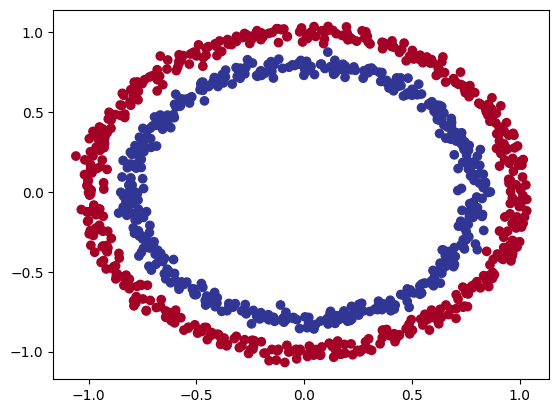

In [ ]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals

### 1.1 Check input and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sampe of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sampe of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn the data into tensors and create train and test splits

In [ ]:
import torch

In [ ]:
type(X), X.dtype, y.dtype

(numpy.ndarray, dtype('float64'), dtype('int64'))

In [ ]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # because the default type of numpy is float64 and the default for torch is float32
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [ ]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2, #Percentage wise
                                                    train_size=0.8,
                                                    random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our ble and red dots.

To do so, we want to:

1. Setup device agonistic code(Gpu or cpu)
2. Construct a model(By subclassing nn.module)
3. Define a loss function and optimizer
4. Create a training and test loop

In [ ]:
import torch
from torch import nn

#Device agnostic code
device = "cuda"if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.module`
2.  Create 2 `nn.linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass
4. Instantiate an instanec of our model class and send it to the target `device`

In [ ]:
# 1. Construct a model

class CircleModelv0(nn.Module):
  def __init__(self):
    super().__init__()
    #2 . Create 2 nn.linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=5)# Takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5,
                             out_features=1)# Takes in 5 features from previous layer and outputs a single layer

  # 3. Define forward() method
  def forward(self, x: torch.tensor)->torch.tensor:
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelv0().to(device)
model_0

CircleModelv0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# # Let's replicate the model above using nn.Squential()
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=5),
#     nn.Linear(in_features=5, out_features=1)
# ).to(device)
# model_0

In [ ]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.3480, -0.2890],
                      [-0.2245, -0.6720],
                      [ 0.5802,  0.5928],
                      [-0.1109, -0.0805],
                      [-0.2886, -0.6386]])),
             ('layer_1.bias',
              tensor([-0.6881,  0.2628, -0.3882, -0.4546, -0.0552])),
             ('layer_2.weight',
              tensor([[-0.1489, -0.1447,  0.0144, -0.0949, -0.1540]])),
             ('layer_2.bias', tensor([-0.2141]))])

In [ ]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape of predictions: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, shape: {X_test.shape}")
print(f"\nFirst 10 predictions: {untrained_preds[:10]}")
print(f"\nFirst 10 test labels: {y_test[:10]}")

Length of predictions: 200, Shape of predictions: torch.Size([200, 1])
Length of test samples: 200, shape: torch.Size([200, 2])

First 10 predictions: tensor([[ 0.0149],
        [ 0.1432],
        [-0.2875],
        [ 0.1004],
        [-0.2337],
        [-0.1558],
        [ 0.1628],
        [ 0.0929],
        [-0.2894],
        [ 0.1524]])

First 10 test labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again this is problem specific

For example for regression you might want MAE(Mean absolute error) or MSE(Mean squared error)

For classification you might want to use binary cross entropy and categorical cross entropy

As a reminder, the loss function measures how *wrong* your model prediction are

And for optimizer, two of the most common and useful are SGD and Adam, however Pytorch has many built-in options.

* We are gonna use `torch.nn.BECWithLogitLoss()`
* For difference optimizers see `torch.optim`

In [ ]:
# Setup loss function
# loss_fn = nn.BCELoss() # Requires inputs to have gone through the sigmoid activation fucntion prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # Has sigmoid activation function built-in, combines both sigmoid and BCELoss

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

### 3. Train the model

To train our model, we're going to need to build a training loop with the following step

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward
5. Optimzier step

### 3.1 Going from raw logits -> prediction probablities -> prediction labels

our model outputs are going to be raw **logits**.

**Logis** is the raw, unnormalized output scores produced by a neural netowrk's final layer before applying an activation function like softmax.

We can convert these **logits** into **prediction probablities** by passing them to some kind of activation function (eg. sigmoid for binary classificaiton and softmax for multiclass classification)

THen we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`-for outputs of softmax

In [ ]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0149],
        [ 0.1432],
        [-0.2875],
        [ 0.1004],
        [-0.2337]])

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
# Use the sigmoid activation function on our model outputs because it's binary classification
# We are turning the logits into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5037],
        [0.5357],
        [0.4286],
        [0.5251],
        [0.4418]])

For our prediction pribability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5 `y=1` (class 1)
* `y_pred_probs` < 0.5 `y=2` (class 2)


In [ ]:
# FInd the predicted labels
y_preds = torch.round(y_pred_probs)

# CHeck for equality
print(torch.eq(y_preds.squeeze(), y_test[:5].to(device)))

tensor([ True, False, False, False, False])


In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
y_preds

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.]])

In [ ]:
### 3.2 Building a training and testing loop

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test =  X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))# logitss -> Pred probs -> pred labels

  # 2. Calculate the loss/accuracy
  loss = loss_fn(y_logits, y_train) # we passed y_logits because the fn expects raw logits becuase it's BCEWithLogits
  train_acc = accuracy_fn(y_train, y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Optimizer step (Gradient desscent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the loss/accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69726, Acc: 49.00% | Test Loss: 0.70528, Test Acc: 46.00%
Epoch: 10 | Loss: 0.69536, Acc: 49.88% | Test Loss: 0.70245, Test Acc: 46.50%
Epoch: 20 | Loss: 0.69441, Acc: 50.25% | Test Loss: 0.70064, Test Acc: 47.00%
Epoch: 30 | Loss: 0.69389, Acc: 50.50% | Test Loss: 0.69937, Test Acc: 45.00%
Epoch: 40 | Loss: 0.69358, Acc: 50.62% | Test Loss: 0.69842, Test Acc: 46.00%
Epoch: 50 | Loss: 0.69339, Acc: 51.25% | Test Loss: 0.69769, Test Acc: 46.50%
Epoch: 60 | Loss: 0.69326, Acc: 51.00% | Test Loss: 0.69712, Test Acc: 45.50%
Epoch: 70 | Loss: 0.69317, Acc: 51.12% | Test Loss: 0.69667, Test Acc: 45.50%
Epoch: 80 | Loss: 0.69311, Acc: 50.88% | Test Loss: 0.69631, Test Acc: 45.50%
Epoch: 90 | Loss: 0.69307, Acc: 50.88% | Test Loss: 0.69601, Test Acc: 45.50%


## 4. Make predicitions and evaluate the model

from metrics it looks like our model isn't learning anything..

So to inspect it let's make some predictions and make them visual

To do so, we;re going to import a function called `plot_decision_boundary()`

In [ ]:
import requests
from pathlib import Path

# Download helper function form learn Pytorch repo if it's not already downloaded
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


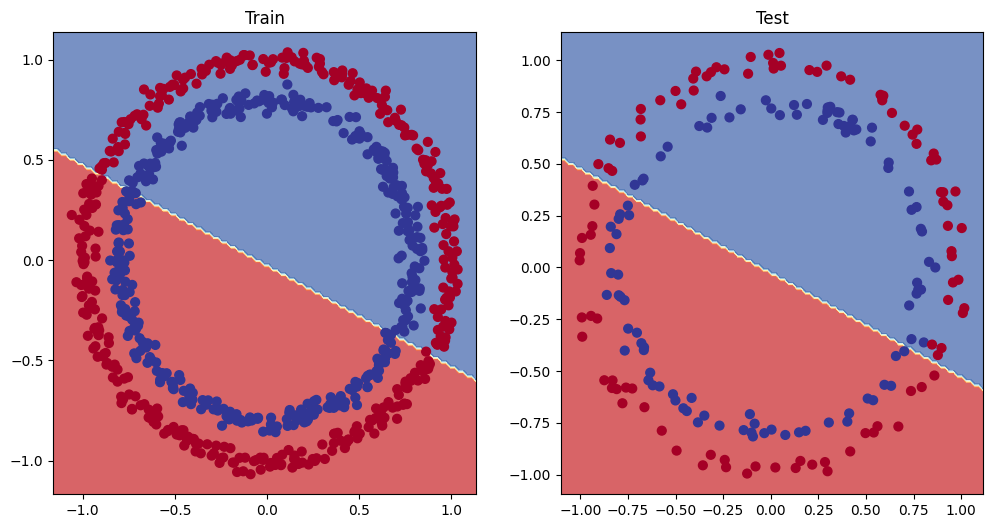

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)
#

## 5. Improving the model (from model perspective)

* Add more layers -give model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden unity to 10 hidden units
* Fit for longer(train for longer)
* changing the activation function, we are currently using sigmoid
* changinng the learning rate
* change the loss function, we are currently using `BCEWithLogitsLoss()`

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we can change, they are referred as **hyperparameters**

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* iNcrease the number of layers: 2-> 3
* Increase the number of epochs: 100->1000

In [ ]:
class CircleModelv1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features = 2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x:torch.tensor) -> torch.tensor:
    return self.layer3(self.layer2(self.layer1(x)))



In [ ]:
model_1 = CircleModelv1().to(device)
model_1

CircleModelv1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Create a loss functioon
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [ ]:
# Write training and testing loop
model_1 = CircleModelv1().to(device)

epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test =  X_test.to(device), y_test.to(device)
for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  train_acc = accuracy_fn(y_train, y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()#Adjusments takes place here

  ##Testing
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_preds)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.70859, Acc: 50.00% | Test Loss: 0.71411, Test Acc: 50.00%
Epoch: 10 | Loss: 0.70859, Acc: 50.00% | Test Loss: 0.71411, Test Acc: 50.00%
Epoch: 20 | Loss: 0.70859, Acc: 50.00% | Test Loss: 0.71411, Test Acc: 50.00%
Epoch: 30 | Loss: 0.70859, Acc: 50.00% | Test Loss: 0.71411, Test Acc: 50.00%
Epoch: 40 | Loss: 0.70859, Acc: 50.00% | Test Loss: 0.71411, Test Acc: 50.00%
Epoch: 50 | Loss: 0.70859, Acc: 50.00% | Test Loss: 0.71411, Test Acc: 50.00%
Epoch: 60 | Loss: 0.70859, Acc: 50.00% | Test Loss: 0.71411, Test Acc: 50.00%
Epoch: 70 | Loss: 0.70859, Acc: 50.00% | Test Loss: 0.71411, Test Acc: 50.00%
Epoch: 80 | Loss: 0.70859, Acc: 50.00% | Test Loss: 0.71411, Test Acc: 50.00%
Epoch: 90 | Loss: 0.70859, Acc: 50.00% | Test Loss: 0.71411, Test Acc: 50.00%
Epoch: 100 | Loss: 0.70859, Acc: 50.00% | Test Loss: 0.71411, Test Acc: 50.00%
Epoch: 110 | Loss: 0.70859, Acc: 50.00% | Test Loss: 0.71411, Test Acc: 50.00%
Epoch: 120 | Loss: 0.70859, Acc: 50.00% | Test Loss: 0.71411, T

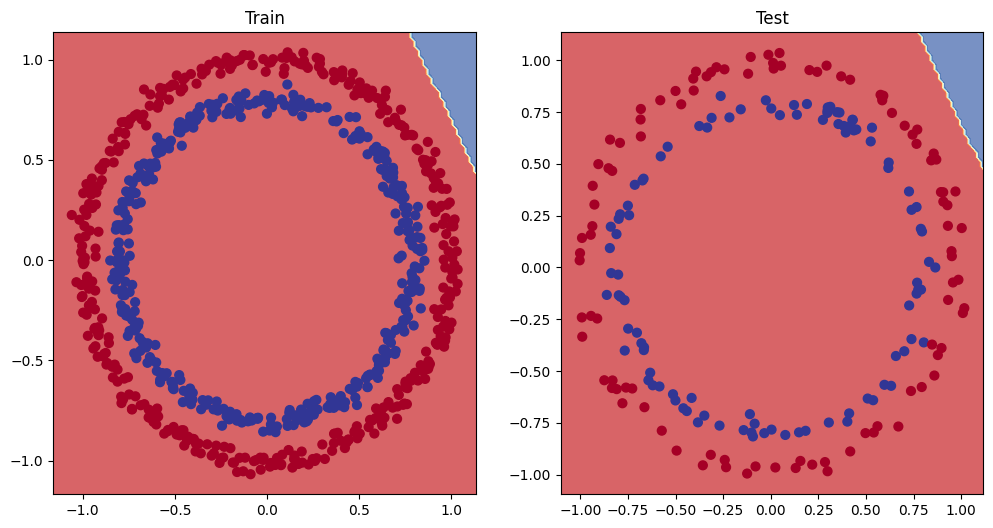

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)
#

In [ ]:
# Let's verify if our model can learn
import torch
from torch import nn
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight*X + bias

# Split the data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:] ,y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)



(80, 80, 20, 20)

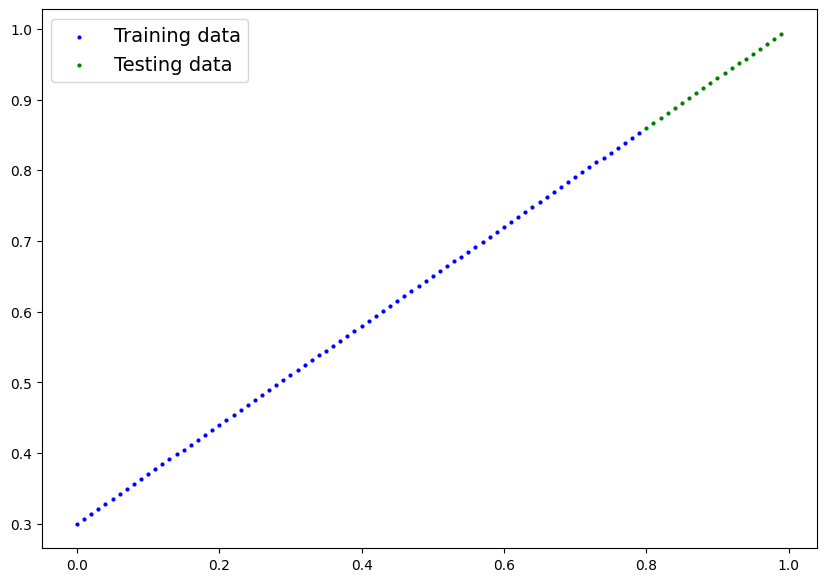

In [ ]:
plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data = X_test,
                 test_labels=y_test)

### 5.2 Adjusting `model_1` to fit straight line

In [ ]:
testModel = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

testModel, device

(Sequential(
   (0): Linear(in_features=1, out_features=10, bias=True)
   (1): Linear(in_features=10, out_features=10, bias=True)
   (2): Linear(in_features=10, out_features=1, bias=True)
 ),
 'cpu')

In [ ]:
model_test = testModel

In [ ]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_test.parameters(), lr=0.01)

In [ ]:
epochs = 1000
torch.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):
  model_test.train()

  y_pred = model_test(X_train)

  loss = loss_fn(y_pred, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_test.eval()
  with torch.inference_mode():
    test_pred = model_test(X_test)
    test_loss = loss_fn(test_pred, y_test)
  if epoch % 10 == 0:
    print(f"epoch: {epoch} | Loss: {loss:.5f} | TestLoss: {test_loss:.5f}")

epoch: 0 | Loss: 0.22992 | TestLoss: 0.39976
epoch: 10 | Loss: 0.07593 | TestLoss: 0.17940
epoch: 20 | Loss: 0.06663 | TestLoss: 0.15529
epoch: 30 | Loss: 0.05704 | TestLoss: 0.13321
epoch: 40 | Loss: 0.04709 | TestLoss: 0.10923
epoch: 50 | Loss: 0.03672 | TestLoss: 0.08512
epoch: 60 | Loss: 0.02589 | TestLoss: 0.05871
epoch: 70 | Loss: 0.01474 | TestLoss: 0.02590
epoch: 80 | Loss: 0.03689 | TestLoss: 0.01105
epoch: 90 | Loss: 0.03938 | TestLoss: 0.00680
epoch: 100 | Loss: 0.04184 | TestLoss: 0.00313
epoch: 110 | Loss: 0.04429 | TestLoss: 0.00283
epoch: 120 | Loss: 0.04671 | TestLoss: 0.00574
epoch: 130 | Loss: 0.04622 | TestLoss: 0.00620
epoch: 140 | Loss: 0.04479 | TestLoss: 0.00545
epoch: 150 | Loss: 0.04338 | TestLoss: 0.00480
epoch: 160 | Loss: 0.04388 | TestLoss: 0.00641
epoch: 170 | Loss: 0.04250 | TestLoss: 0.00570
epoch: 180 | Loss: 0.04114 | TestLoss: 0.00509
epoch: 190 | Loss: 0.04166 | TestLoss: 0.00671
epoch: 200 | Loss: 0.04032 | TestLoss: 0.00605
epoch: 210 | Loss: 0.039

In [ ]:
weight, bias

(0.7, 0.3)

In [ ]:
model_test.eval()
with torch.inference_mode(): # inference mode removes gradient descent because we are making predictions we are not training
  y_preds = model_test(X_test)

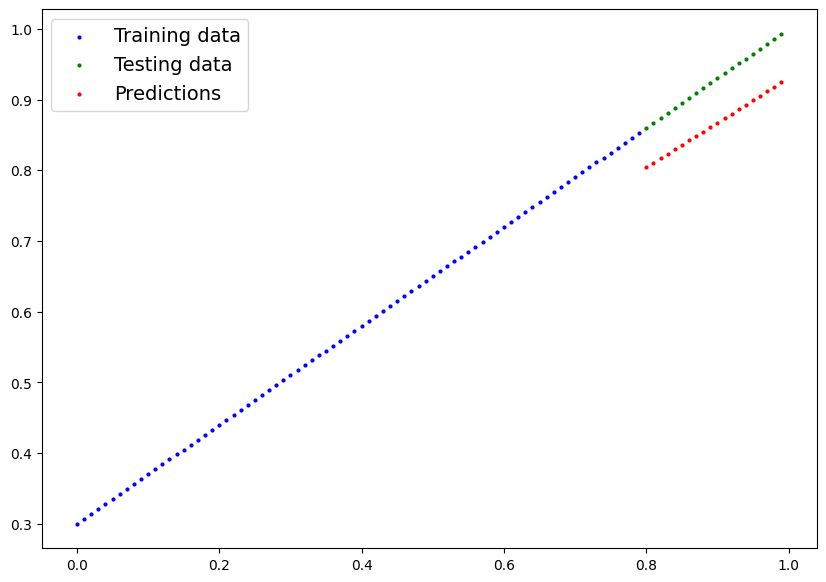

In [ ]:
plot_predictions(train_data = X_train.cpu(),
                 train_labels = y_train.cpu(),
                 test_data = X_test.cpu(),
                 test_labels = y_test.cpu(),
                 predictions = y_preds.cpu())

## 6. The missing piece: non-linearity

"what patterns could you draw if you were given an infinite amount of a straight and non-straight lines?"

or in machine learning terms, an infinite(but really it's finite) of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

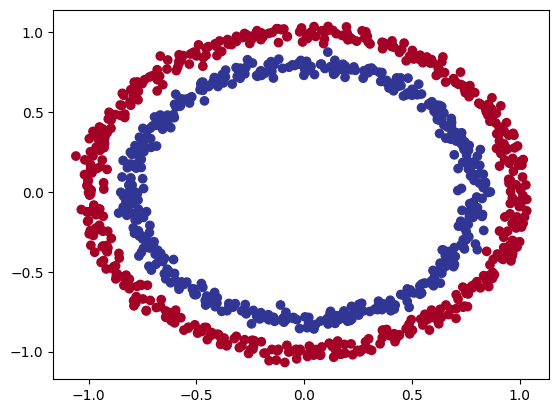

In [ ]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.2, random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

* Linear = straight line
* Non-linear = non-Straight line

In [ ]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelv2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # Max(0, x), non-linear activation function

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelv2().to(device)
model_3

CircleModelv2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
## setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr = 0.1)

In [ ]:
X_train[:5], y_test[:5], device


(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 1., 0., 1.]),
 'cpu')

In [ ]:
# Training and testing

epochs = 1000
X_train, y_train= X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_3.train()

  y_logits = model_3(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  train_acc = accuracy_fn(y_train, y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  #testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Acc: 50.00% | Test Loss: 0.69319, Test Acc: 50.00%
Epoch: 10 | Loss: 0.69248, Acc: 50.50% | Test Loss: 0.69260, Test Acc: 50.00%
Epoch: 20 | Loss: 0.69225, Acc: 59.13% | Test Loss: 0.69231, Test Acc: 56.50%
Epoch: 30 | Loss: 0.69209, Acc: 70.25% | Test Loss: 0.69212, Test Acc: 68.00%
Epoch: 40 | Loss: 0.69195, Acc: 68.38% | Test Loss: 0.69195, Test Acc: 71.00%
Epoch: 50 | Loss: 0.69181, Acc: 58.25% | Test Loss: 0.69177, Test Acc: 58.00%
Epoch: 60 | Loss: 0.69168, Acc: 54.00% | Test Loss: 0.69161, Test Acc: 54.50%
Epoch: 70 | Loss: 0.69155, Acc: 53.12% | Test Loss: 0.69146, Test Acc: 53.00%
Epoch: 80 | Loss: 0.69141, Acc: 52.62% | Test Loss: 0.69132, Test Acc: 53.00%
Epoch: 90 | Loss: 0.69128, Acc: 52.75% | Test Loss: 0.69117, Test Acc: 53.00%
Epoch: 100 | Loss: 0.69115, Acc: 52.88% | Test Loss: 0.69102, Test Acc: 52.50%
Epoch: 110 | Loss: 0.69103, Acc: 52.88% | Test Loss: 0.69088, Test Acc: 53.50%
Epoch: 120 | Loss: 0.69090, Acc: 53.12% | Test Loss: 0.69074, T

### 6.4 Evaluating a model trained with non-linear activation functions

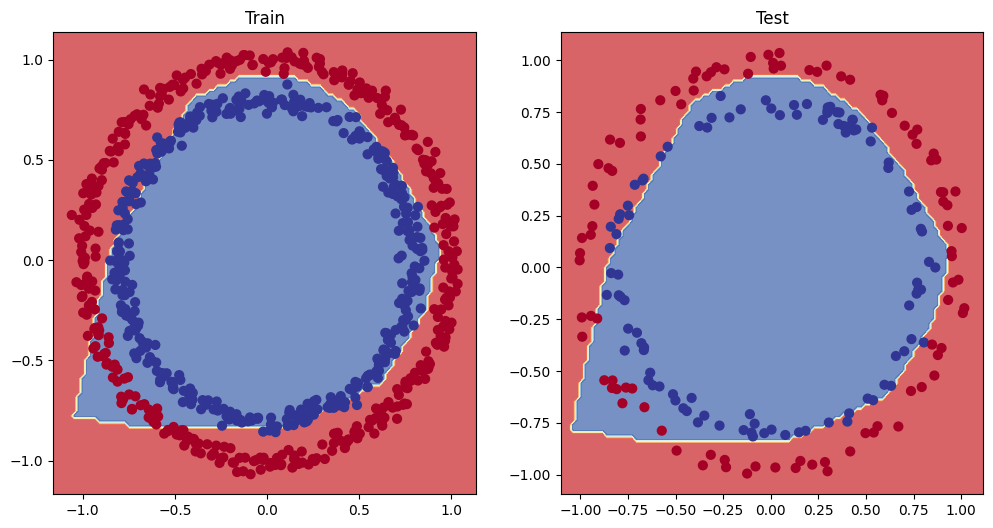

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)
#

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the odel what to learn, we give it the tools to discover patterns in data and it tries figure out the patterns on it's own

And these tool are linear and non linear functions

In [ ]:
# Create a tensor

A = torch.arange(-10 ,10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [ ]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

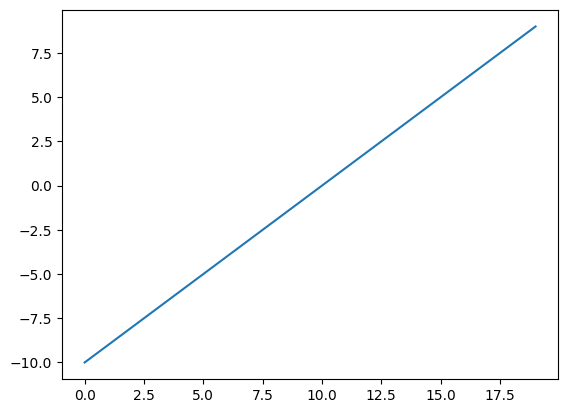

In [ ]:
# Visualize the tensor
plt.plot(A)

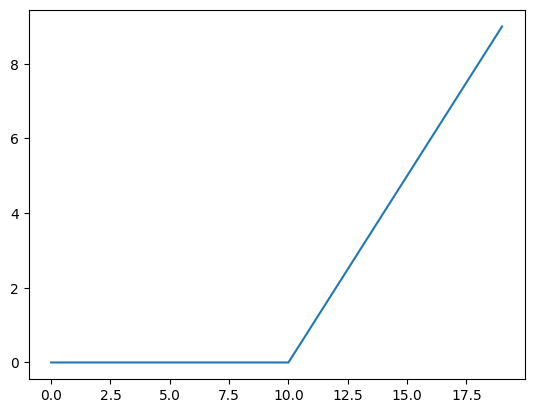

In [ ]:
plt.plot(torch.relu(A))

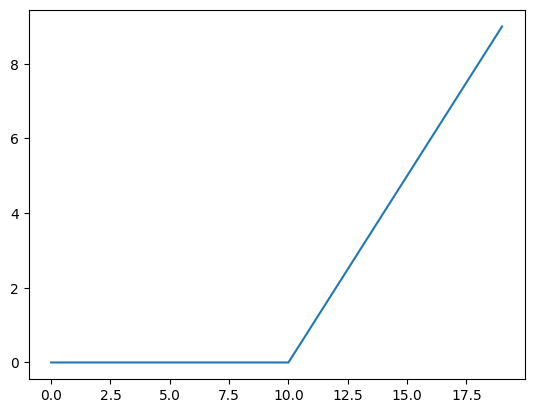

In [ ]:
def relu(x :torch.Tensor) -> torch.Tensor:
  return torch.max(torch.tensor(0), x)
plt.plot(relu(A))

In [ ]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
  return 1 / (1+torch.exp(-x))

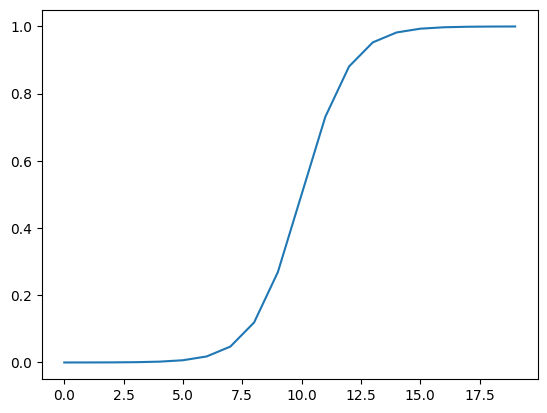

In [ ]:
plt.plot(torch.sigmoid(A))

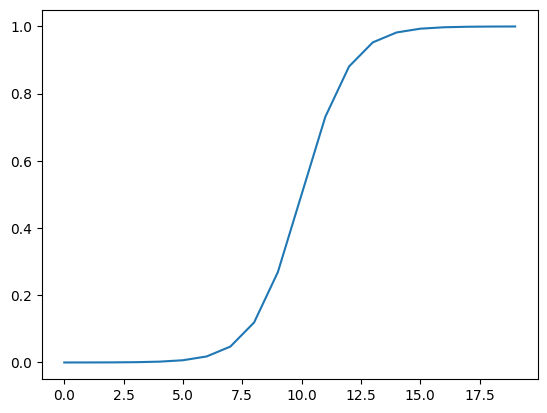

In [ ]:
plt.plot(sigmoid(A))

### 8. Putting it all togetehr with multi-class clasfficiation problem

* Binary classification - one thing or another (cat vs dog,  spam not spam, fraud or not fraud)
* Multi-class classification  - more than one thing or another (car vs dog vs chicken)

### 8.1 Creating a toy multi-class dataset

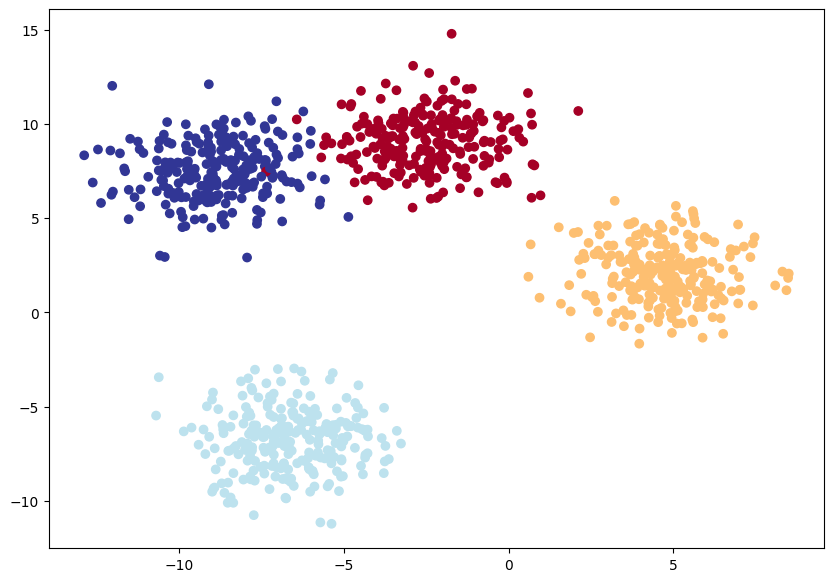

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # It will mix it up a little
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state= RANDOM_SEED)

# 4. Visualize
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model in PyTorch

In [ ]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Build a multi class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )
    self.relu = nn.ReLU()

  def forward(self, x:torch.Tensor)->torch.Tensor:
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8
                    ).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
  (relu): ReLU()
)

In [ ]:
# Setup loss function and an optimzer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probabilities for a multi-class Pytorch model

In order to evaluare and train and test our model, we need to convert our model's output (logits) to prediction probabilities and then to prediction labels

Logits(raw output) -> Pred probs(`torch.softmax`) -> Pred labels(`torch.argmax`)

In [ ]:
all#Let;s get some raw output of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))
y_logits[:5]

tensor([[-0.0735,  0.8298, -0.4357, -0.0443],
        [-0.1289,  0.7998, -0.0647, -0.0891],
        [ 0.0626,  0.7235, -0.4863,  0.2686],
        [-0.1734,  0.5965, -0.1321,  0.0999],
        [ 0.1621,  0.8828, -0.3559, -0.0679]])

In [ ]:
# Convert our model's logit output to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])
y_pred_probs.size()

tensor([[ 0.4696,  6.2800, -5.7864, -3.6374],
        [ 5.6935,  0.2125, -4.8463, -0.2198],
        [-2.4202, -0.0780,  9.2742, -0.4877],
        [-1.6447, -0.0548,  5.1771,  0.2618],
        [ 2.8971, -0.1667, -2.7965,  0.7422]], grad_fn=<SliceBackward0>)
tensor([[2.9869e-03, 9.9696e-01, 5.7316e-06, 4.9155e-05],
        [9.9315e-01, 4.1369e-03, 2.6282e-05, 2.6848e-03],
        [8.3395e-06, 8.6760e-05, 9.9985e-01, 5.7595e-05],
        [1.0749e-03, 5.2709e-03, 9.8642e-01, 7.2339e-03],
        [8.5764e-01, 4.0059e-02, 2.8880e-03, 9.9414e-02]],
       grad_fn=<SliceBackward0>)


torch.Size([800, 4])

In [ ]:
#Convert our model's prediction probabiliites to prediction labels
y_preds = torch.argmax(y_pred_probs, dim =1)
y_preds, len(y_preds)

(tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0, 0, 0, 3, 2, 3, 2, 1, 1, 3, 2, 2, 2, 3, 1,
         3, 2, 3, 0, 1, 0, 0, 1, 1, 3, 0, 2, 2, 1, 1, 3, 1, 1, 2, 3, 3, 0, 0, 0,
         1, 0, 0, 0, 2, 0, 1, 1, 3, 0, 2, 2, 3, 1, 0, 2, 1, 3, 2, 2, 2, 1, 0, 2,
         3, 1, 1, 1, 2, 0, 0, 1, 2, 3, 1, 3, 3, 2, 3, 3, 2, 2, 1, 0, 0, 1, 2, 1,
         3, 1, 2, 1, 3, 3, 3, 0, 2, 1, 2, 3, 1, 1, 2, 0, 3, 3, 2, 3, 2, 0, 3, 2,
         0, 0, 2, 2, 0, 1, 2, 0, 3, 3, 2, 3, 2, 1, 3, 1, 1, 1, 1, 0, 0, 1, 0, 2,
         3, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 2, 2, 0, 0, 3, 0, 3, 0, 3, 0, 2, 3, 1,
         2, 2, 2, 3, 0, 1, 1, 0, 1, 2, 0, 3, 2, 1, 3, 2, 3, 0, 3, 1, 1, 2, 2, 2,
         2, 2, 2, 0, 3, 3, 2, 1, 1, 2, 3, 1, 0, 0, 1, 3, 0, 1, 3, 3, 2, 3, 3, 3,
         1, 0, 0, 1, 0, 3, 2, 1, 0, 3, 0, 0, 3, 1, 0, 1, 0, 2, 2, 0, 0, 3, 3, 2,
         0, 2, 0, 3, 1, 3, 0, 2, 2, 0, 1, 1, 0, 2, 1, 1, 1, 0, 1, 3, 1, 1, 0, 2,
         2, 3, 1, 0, 1, 2, 3, 1, 2, 0, 3, 1, 3, 3, 3, 0, 3, 3, 3, 2, 3, 3, 1, 0,
         2, 2, 2, 2, 3, 1, 2

In [ ]:
torch.argmax(y_pred_probs[0])

tensor(1)

### 8.5 Creating a training loop and testing loop for a multi class Pytorch model

In [ ]:
y_blob_train.dtype

torch.int64

In [ ]:
# Training loop

epochs = 100
X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device)
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)


for epoch in range(epochs):
  model_4.train()
  y_logits = model_4(X_blob_train)
  y_pred_probs = torch.softmax(y_logits, dim=1)
  y_preds = torch.argmax(y_pred_probs, dim =1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_blob_train, y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred_probs = torch.softmax(test_logits, dim=1)
    test_preds = torch.argmax(test_pred_probs, dim =1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_blob_test, test_preds)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.55093, Acc: 87.62% | Test Loss: 1.37722, Test Acc: 20.50%
Epoch: 10 | Loss: 0.76207, Acc: 87.62% | Test Loss: 0.74287, Test Acc: 70.00%
Epoch: 20 | Loss: 0.56728, Acc: 87.62% | Test Loss: 0.56981, Test Acc: 95.50%
Epoch: 30 | Loss: 0.42862, Acc: 87.62% | Test Loss: 0.43841, Test Acc: 97.50%
Epoch: 40 | Loss: 0.33127, Acc: 87.62% | Test Loss: 0.34674, Test Acc: 98.50%
Epoch: 50 | Loss: 0.27204, Acc: 87.62% | Test Loss: 0.28930, Test Acc: 98.50%
Epoch: 60 | Loss: 0.23324, Acc: 87.62% | Test Loss: 0.24990, Test Acc: 99.00%
Epoch: 70 | Loss: 0.20492, Acc: 87.62% | Test Loss: 0.22011, Test Acc: 99.00%
Epoch: 80 | Loss: 0.18139, Acc: 87.62% | Test Loss: 0.19432, Test Acc: 99.50%
Epoch: 90 | Loss: 0.15544, Acc: 87.62% | Test Loss: 0.16418, Test Acc: 99.50%


### 8.6 Making and evaluating prediction with a pytorch multi-class model

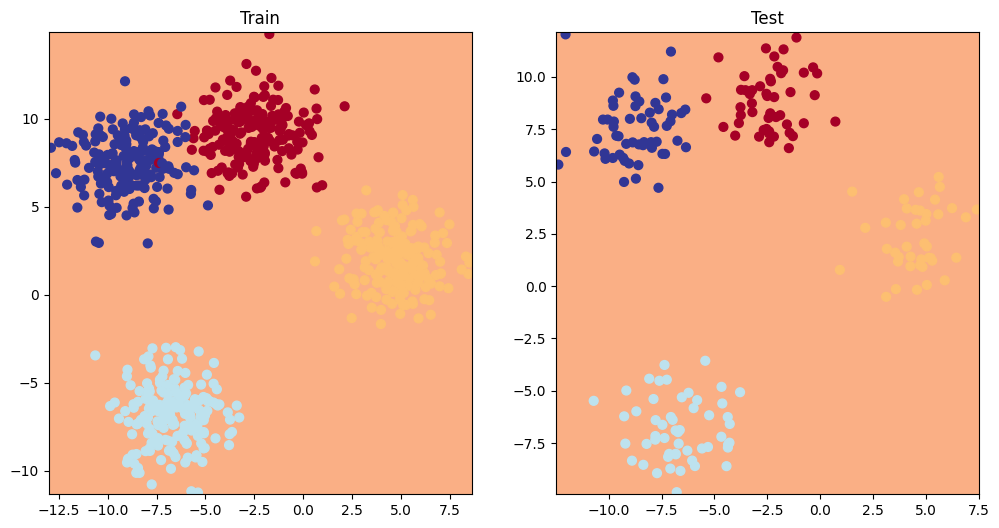

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)
#

### 9. A few more classification metrics (to evaluate our classification model)

* Accuracy - out of 100 sampels, how many does our model get right(Good when you have balanced class)
* Precision (Good when you have unbalanced class)
* Recall (Good when you have unbalanced class)
* F1-score - combine Precision and Recall
* Confusion matrix
* Classification report

* **Note** If you increase precision you lower recall and vise-versa

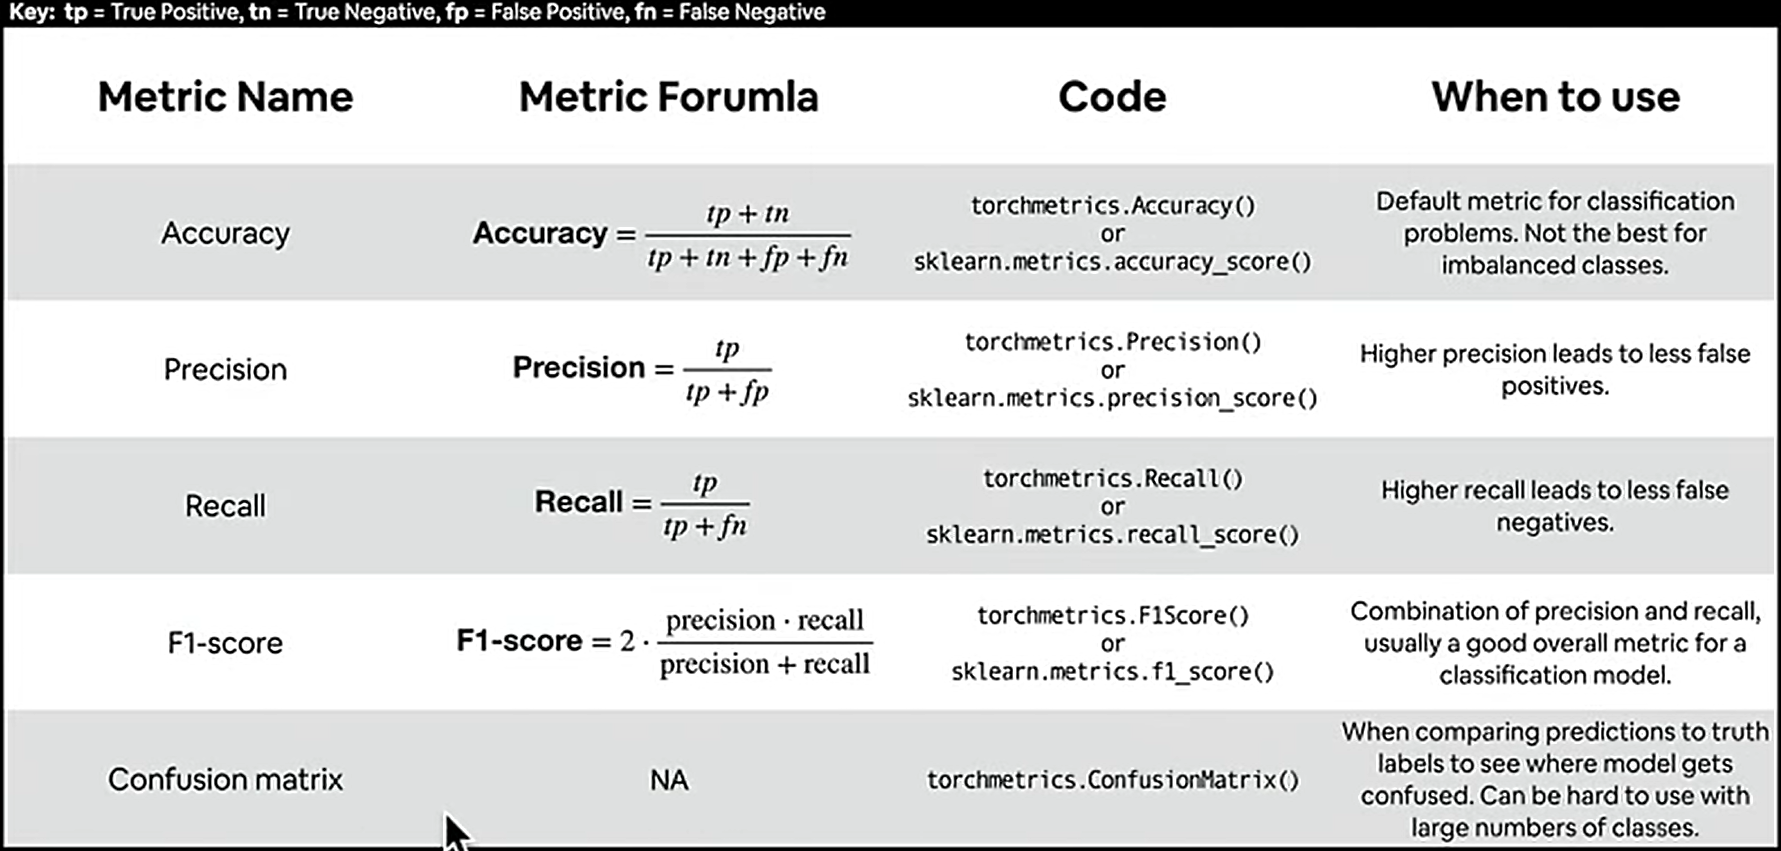

In [ ]:
!pip install torchmetrics

In [ ]:
next(model_4.parameters()).device, X_blob_test.device

(device(type='cpu'), device(type='cpu'))

In [ ]:
model_4.eval()
model_4.to(device)
with torch.inference_mode():
  y_preds = model_4(X_blob_test)

In [ ]:
from torchmetrics import Accuracy

#Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.2050)